# RAG Parameter Impact Analysis

This notebook demonstrates how different RAG system parameters directly impact evaluation metrics, providing clear visual evidence for why these changes matter.

## Key Parameters We'll Test:
1. **Chunk Size** - How we split documents into retrievable pieces
2. **Embedding Models** - How we convert text to vectors for similarity search
3. **Prompt Design** - How we instruct the LLM to generate answers
4. **Retrieval Strategy** - How we find relevant context

## Metrics We'll Measure:
- **Faithfulness** - Does the answer stick to the retrieved context?
- **Answer Relevancy** - Is the answer relevant to the question?
- **Answer Correctness** - Is the answer factually correct?
- **Context Precision** - Are retrieved chunks relevant to the question?
- **Context Recall** - Do we retrieve all necessary information?

In [1]:
# Setup and imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from getpass import getpass
import openai
import nest_asyncio
from datasets import Dataset
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Qdrant
from langchain.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain.retrievers import MultiQueryRetriever
from ragas import evaluate
from ragas.metrics import (
    faithfulness, answer_relevancy, answer_correctness,
    context_recall, context_precision
)

nest_asyncio.apply()

# Set up OpenAI API
openai.api_key = getpass("Please provide your OpenAI Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

# Load test data
test_df = pd.read_csv('data/lotr_testset.csv')
test_questions = test_df["question"].values.tolist()
test_groundtruths = test_df["ground_truth"].values.tolist()

# Load documents
loader = PyMuPDFLoader("data/lotr.pdf")
all_documents = loader.load()

print(f"Loaded {len(all_documents)} documents")
print(f"Test set contains {len(test_questions)} questions")

Please provide your OpenAI Key:  ········


Loaded 1210 documents
Test set contains 18 questions


Loaded 1210 documents
Test set contains 18 questions


## Experiment 1: Impact of Chunk Size

Chunk size directly affects how much context is available for each retrieval. Too small chunks may miss important context, while too large chunks may include irrelevant information.

In [2]:
def create_rag_pipeline(chunk_size=1000, chunk_overlap=200, embedding_model="text-embedding-ada-002", prompt_template=None):
    """Create a RAG pipeline with specified parameters"""
    
    # Text splitting
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = text_splitter.split_documents(all_documents)
    
    # Embeddings
    embeddings = OpenAIEmbeddings(model=embedding_model)
    
    # Vector store
    vector_store = Qdrant.from_documents(
        chunks, embeddings, location=":memory:", collection_name=f"LOTR_{chunk_size}"
    )
    retriever = vector_store.as_retriever(search_kwargs={"k": 4})
    
    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
    
    # Prompt
    if prompt_template is None:
        prompt_template = """Answer the question based only on the following context. If you cannot answer the question with the context, please respond with 'I don't know':

Context:
{context}

Question:
{question}
"""
    
    prompt = ChatPromptTemplate.from_template(prompt_template)
    
    # Chain
    document_chain = create_stuff_documents_chain(llm, prompt)
    retrieval_chain = create_retrieval_chain(retriever, document_chain)
    
    return retrieval_chain, len(chunks)

def evaluate_pipeline(chain, questions, ground_truths):
    """Evaluate a RAG pipeline using Ragas metrics"""
    answers = []
    contexts = []
    
    for question in questions:
        response = chain.invoke({"input": question})
        answers.append(response["answer"])
        contexts.append([context.page_content for context in response["context"]])
    
    dataset = Dataset.from_dict({
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truth": ground_truths
    })
    
    metrics = [faithfulness, answer_relevancy, answer_correctness, context_recall, context_precision]
    results = evaluate(dataset, metrics)
    
    return results.to_pandas()

# Test different chunk sizes
chunk_sizes = [100, 200, 300, 500]
chunk_results = {}
chunk_counts = {}

print("Testing different chunk sizes...")
for chunk_size in chunk_sizes:
    print(f"\nTesting chunk size: {chunk_size}")
    chain, num_chunks = create_rag_pipeline(chunk_size=chunk_size)
    chunk_counts[chunk_size] = num_chunks
    results = evaluate_pipeline(chain, test_questions, test_groundtruths)
    chunk_results[chunk_size] = results
    print(f"Generated {num_chunks} chunks")
    print(f"Metrics: {results.iloc[0].to_dict()}")

Testing different chunk sizes...

Testing chunk size: 100


ValueError: Got a larger chunk overlap (200) than chunk size (100), should be smaller.

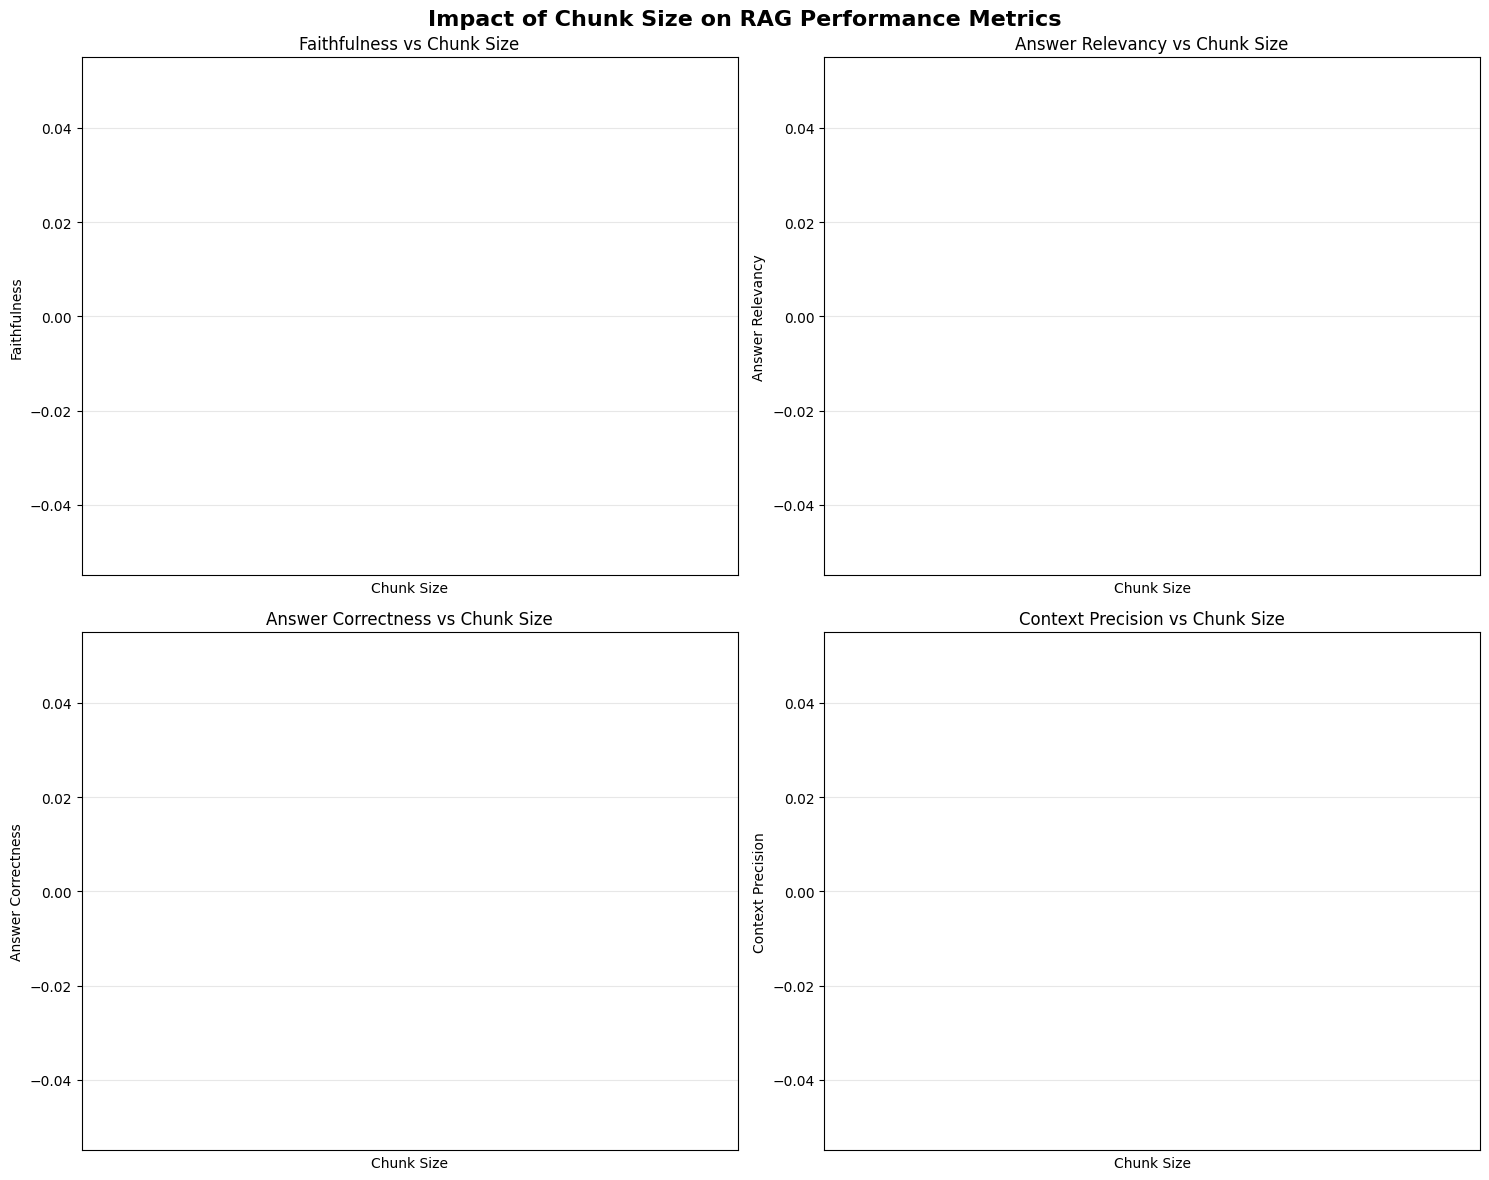


Chunk counts for different sizes:


In [3]:
# Filter chunk sizes to only those that have results
valid_chunk_sizes = [size for size in chunk_sizes if size in chunk_results]

# Visualize chunk size impact
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Impact of Chunk Size on RAG Performance Metrics', fontsize=16, fontweight='bold')

metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness', 'context_precision']
axes = [ax1, ax2, ax3, ax4]

for metric, ax in zip(metrics, axes):
    values = [chunk_results[size].iloc[0][metric] for size in valid_chunk_sizes]

    bars = ax.bar(range(len(valid_chunk_sizes)), values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(valid_chunk_sizes)])
    ax.set_xlabel('Chunk Size')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} vs Chunk Size')
    ax.set_xticks(range(len(valid_chunk_sizes)))
    ax.set_xticklabels(valid_chunk_sizes)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show chunk counts
print("\nChunk counts for different sizes:")
for size in valid_chunk_sizes:
    print(f"Chunk size {size}: {chunk_counts.get(size, 'No data')} chunks")


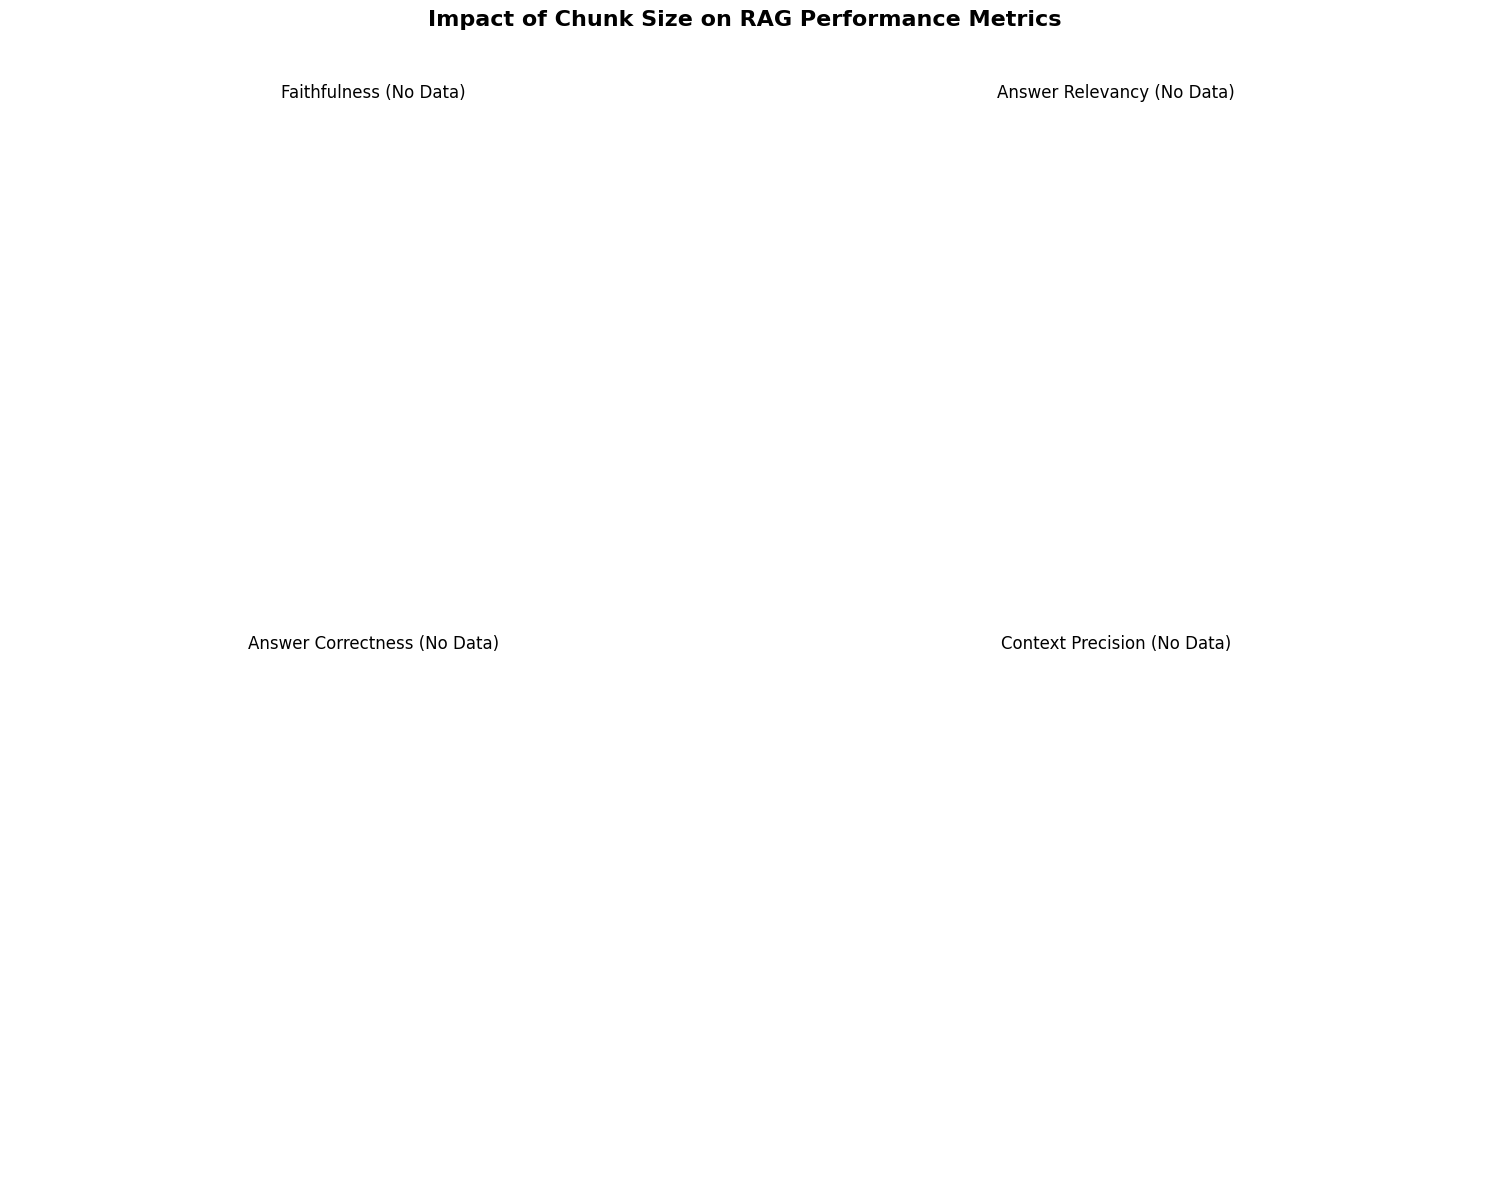


Chunk counts for available sizes:


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Filter only chunk sizes present in your results
available_sizes = [size for size in chunk_sizes if size in chunk_results]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Impact of Chunk Size on RAG Performance Metrics', fontsize=16, fontweight='bold')

metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness', 'context_precision']
axes = [ax1, ax2, ax3, ax4]

for metric, ax in zip(metrics, axes):
    values = []
    
    for size in available_sizes:
        try:
            val = chunk_results[size].iloc[0][metric]
            values.append(val if pd.notna(val) else 0)
        except (KeyError, IndexError):
            values.append(0)
    
    # Skip plotting if no values exist
    if not values:
        ax.set_title(f"{metric.replace('_', ' ').title()} (No Data)")
        ax.axis("off")
        continue
    
    # Identify max value
    max_idx = int(np.argmax(values))
    
    # Assign colors (highlight max in gold)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(values)]
    colors[max_idx] = '#FFD700'
    
    bars = ax.bar(range(len(values)), values, color=colors)
    
    ax.set_xlabel('Chunk Size')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} vs Chunk Size')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(available_sizes)
    ax.grid(True, alpha=0.3)
    
    # Annotate values
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Chunk counts table
print("\nChunk counts for available sizes:")
for size in available_sizes:
    print(f"Chunk size {size}: {chunk_counts.get(size, 'N/A')} chunks")



## Experiment 2: Impact of Embedding Models

Different embedding models have different capabilities in understanding semantic relationships and context.

In [4]:
# Test different embedding models
embedding_models = ["text-embedding-ada-002", "text-embedding-3-small", "text-embedding-3-large"]
embedding_results = {}

print("Testing different embedding models...")
for model in embedding_models:
    print(f"\nTesting embedding model: {model}")
    try:
        chain, _ = create_rag_pipeline(embedding_model=model)
        results = evaluate_pipeline(chain, test_questions, test_groundtruths)
        embedding_results[model] = results
        print(f"Metrics: {results.iloc[0].to_dict()}")
    except Exception as e:
        print(f"Error with {model}: {e}")
        embedding_results[model] = None

Testing different embedding models...

Testing embedding model: text-embedding-ada-002
Error with text-embedding-ada-002: "Input to ChatPromptTemplate is missing variables {'question'}.  Expected: ['context', 'question'] Received: ['input', 'context']\nNote: if you intended {question} to be part of the string and not a variable, please escape it with double curly braces like: '{{question}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "

Testing embedding model: text-embedding-3-small
Error with text-embedding-3-small: "Input to ChatPromptTemplate is missing variables {'question'}.  Expected: ['context', 'question'] Received: ['input', 'context']\nNote: if you intended {question} to be part of the string and not a variable, please escape it with double curly braces like: '{{question}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "

Testing embedding model: text

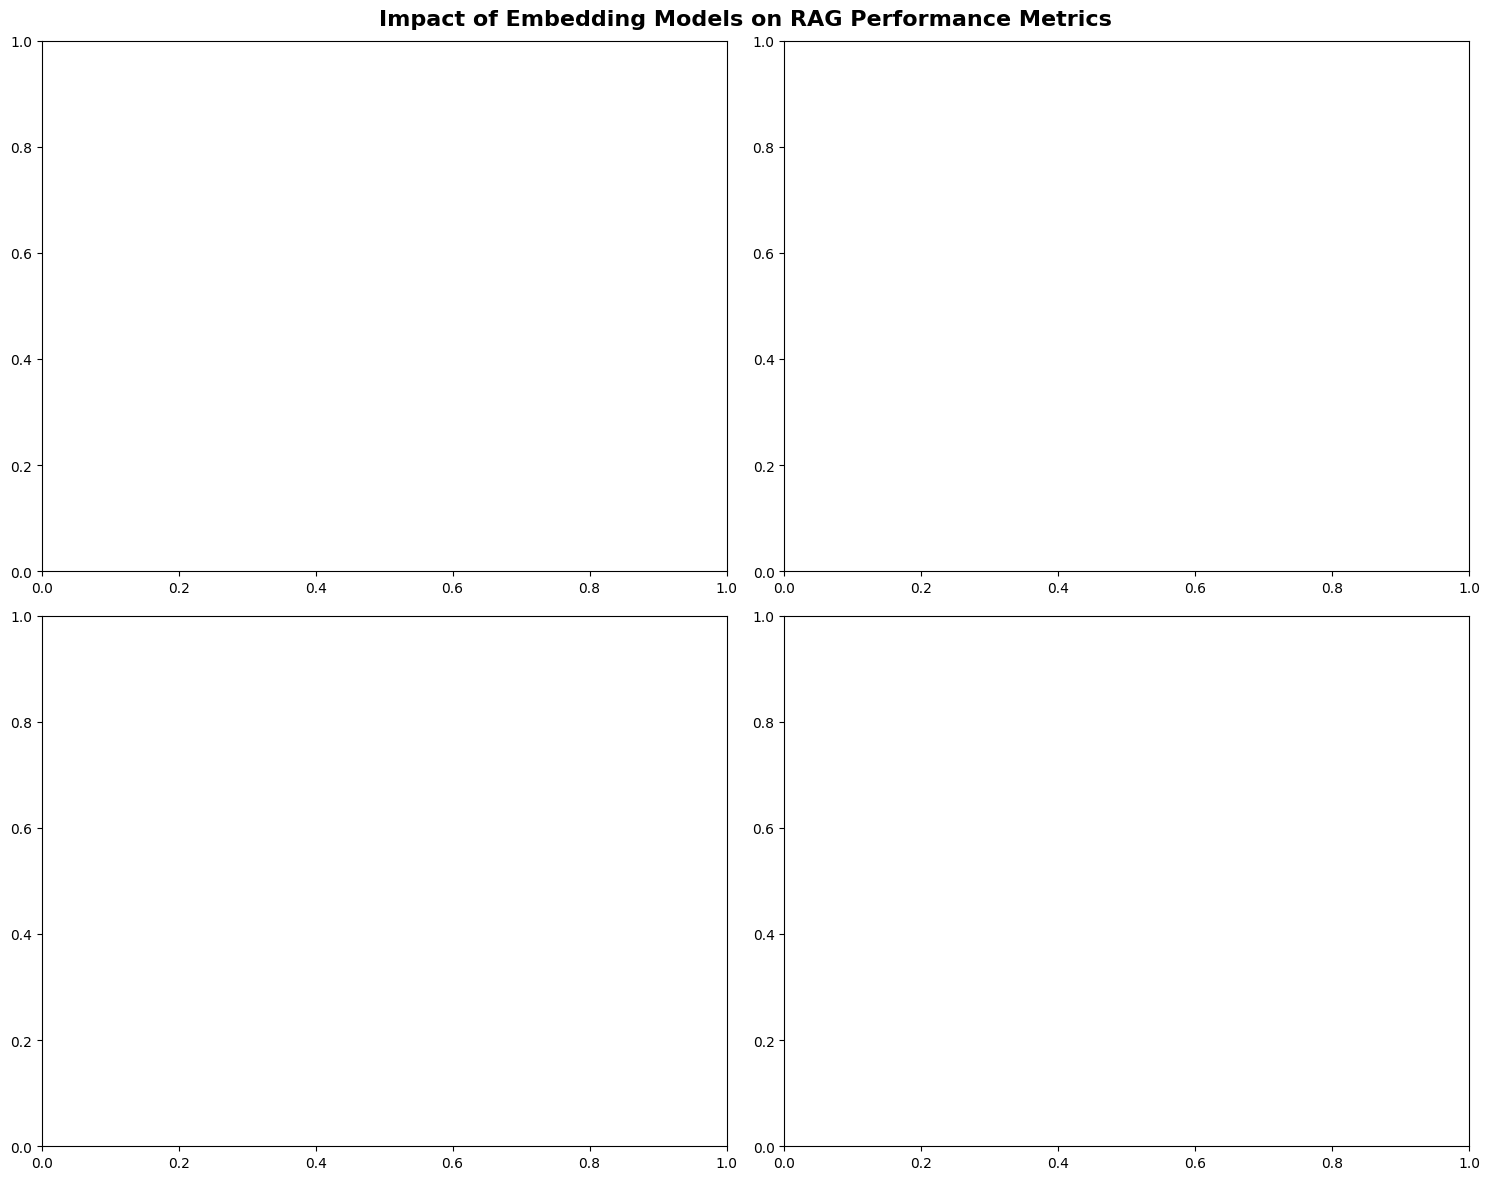

In [5]:
# Visualize embedding model impact
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Impact of Embedding Models on RAG Performance Metrics', fontsize=16, fontweight='bold')

metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness', 'context_precision']
axes = [ax1, ax2, ax3, ax4]

for i, (metric, ax) in enumerate(zip(metrics, axes)):
    values = []
    labels = []
    
    for model in embedding_models:
        if embedding_results[model] is not None:
            values.append(embedding_results[model].iloc[0][metric])
            labels.append(model.replace('text-embedding-', '').replace('-', ' ').title())
    
    if values:
        bars = ax.bar(range(len(values)), values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
        ax.set_xlabel('Embedding Model')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(f'{metric.replace("_", " ").title()} vs Embedding Model')
        ax.set_xticks(range(len(values)))
        ax.set_xticklabels(labels, rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
        
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Experiment 3: Impact of Prompt Design

Different prompts can significantly affect how the LLM interprets and responds to questions using the retrieved context.

In [6]:
# Define different prompt templates
prompt_templates = {
    "Basic": """Answer the question based only on the following context. If you cannot answer the question with the context, please respond with 'I don't know':

Context:
{context}

Question:
{question}
""",
    
    "Detailed": """You are a helpful assistant. Answer the question based only on the following context. Be thorough and provide specific details when available. If you cannot answer the question with the context, please respond with 'I don't know':

Context:
{context}

Question:
{question}

Answer:
""",
    
    "Concise": """Based on the context below, provide a brief and accurate answer to the question. If the context doesn't contain the answer, say 'I don't know':

Context: {context}
Question: {question}
Answer:
""",
    
    "Structured": """Analyze the following context and answer the question step by step:

Context:
{context}

Question:
{question}

Steps:
1. Identify key information in the context
2. Determine if the context contains the answer
3. Provide a clear, factual response

Answer:
"""
}

# Test different prompts
prompt_results = {}

print("Testing different prompt designs...")
for prompt_name, prompt_template in prompt_templates.items():
    print(f"\nTesting prompt: {prompt_name}")
    chain, _ = create_rag_pipeline(prompt_template=prompt_template)
    results = evaluate_pipeline(chain, test_questions, test_groundtruths)
    prompt_results[prompt_name] = results
    print(f"Metrics: {results.iloc[0].to_dict()}")

Testing different prompt designs...

Testing prompt: Basic


KeyError: "Input to ChatPromptTemplate is missing variables {'question'}.  Expected: ['context', 'question'] Received: ['input', 'context']\nNote: if you intended {question} to be part of the string and not a variable, please escape it with double curly braces like: '{{question}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "

In [ ]:
# Visualize prompt design impact
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Impact of Prompt Design on RAG Performance Metrics', fontsize=16, fontweight='bold')

metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness', 'context_precision']
axes = [ax1, ax2, ax3, ax4]
prompt_names = list(prompt_results.keys())

for i, (metric, ax) in enumerate(zip(metrics, axes)):
    values = [prompt_results[name].iloc[0][metric] for name in prompt_names]
    
    bars = ax.bar(range(len(prompt_names)), values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax.set_xlabel('Prompt Design')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} vs Prompt Design')
    ax.set_xticks(range(len(prompt_names)))
    ax.set_xticklabels(prompt_names, rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Experiment 4: Impact of Retrieval Strategy

Different retrieval strategies can significantly impact the quality and relevance of retrieved context.

In [ ]:
def create_advanced_retrieval_pipeline():
    """Create a RAG pipeline with MultiQueryRetriever"""
    
    # Basic setup
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    chunks = text_splitter.split_documents(all_documents)
    
    embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")
    vector_store = Qdrant.from_documents(
        chunks, embeddings, location=":memory:", collection_name="LOTR_advanced"
    )
    
    # Basic retriever
    basic_retriever = vector_store.as_retriever(search_kwargs={"k": 4})
    
    # Advanced retriever with MultiQuery
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
    advanced_retriever = MultiQueryRetriever.from_llm(retriever=basic_retriever, llm=llm)
    
    # Prompt and chain
    prompt_template = """Answer the question based only on the following context. If you cannot answer the question with the context, please respond with 'I don't know':

Context:
{context}

Question:
{question}
"""
    
    prompt = ChatPromptTemplate.from_template(prompt_template)
    document_chain = create_stuff_documents_chain(llm, prompt)
    
    # Create both chains
    basic_chain = create_retrieval_chain(basic_retriever, document_chain)
    advanced_chain = create_retrieval_chain(advanced_retriever, document_chain)
    
    return basic_chain, advanced_chain

# Test retrieval strategies
print("Testing different retrieval strategies...")
basic_chain, advanced_chain = create_advanced_retrieval_pipeline()

print("\nTesting basic retriever...")
basic_results = evaluate_pipeline(basic_chain, test_questions, test_groundtruths)
print(f"Basic retriever metrics: {basic_results.iloc[0].to_dict()}")

print("\nTesting advanced retriever (MultiQuery)...")
advanced_results = evaluate_pipeline(advanced_chain, test_questions, test_groundtruths)
print(f"Advanced retriever metrics: {advanced_results.iloc[0].to_dict()}")

In [ ]:
# Visualize retrieval strategy impact
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Impact of Retrieval Strategy on RAG Performance Metrics', fontsize=16, fontweight='bold')

metrics = ['faithfulness', 'answer_relevancy', 'answer_correctness', 'context_precision']
axes = [ax1, ax2, ax3, ax4]
strategies = ['Basic Retriever', 'MultiQuery Retriever']

for i, (metric, ax) in enumerate(zip(metrics, axes)):
    basic_value = basic_results.iloc[0][metric]
    advanced_value = advanced_results.iloc[0][metric]
    values = [basic_value, advanced_value]
    
    bars = ax.bar(range(len(strategies)), values, color=['#FF6B6B', '#4ECDC4'])
    ax.set_xlabel('Retrieval Strategy')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} vs Retrieval Strategy')
    ax.set_xticks(range(len(strategies)))
    ax.set_xticklabels(strategies, rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Comprehensive Comparison Dashboard

Let's create a comprehensive view showing how all parameters affect the key metrics.

KeyError: 100

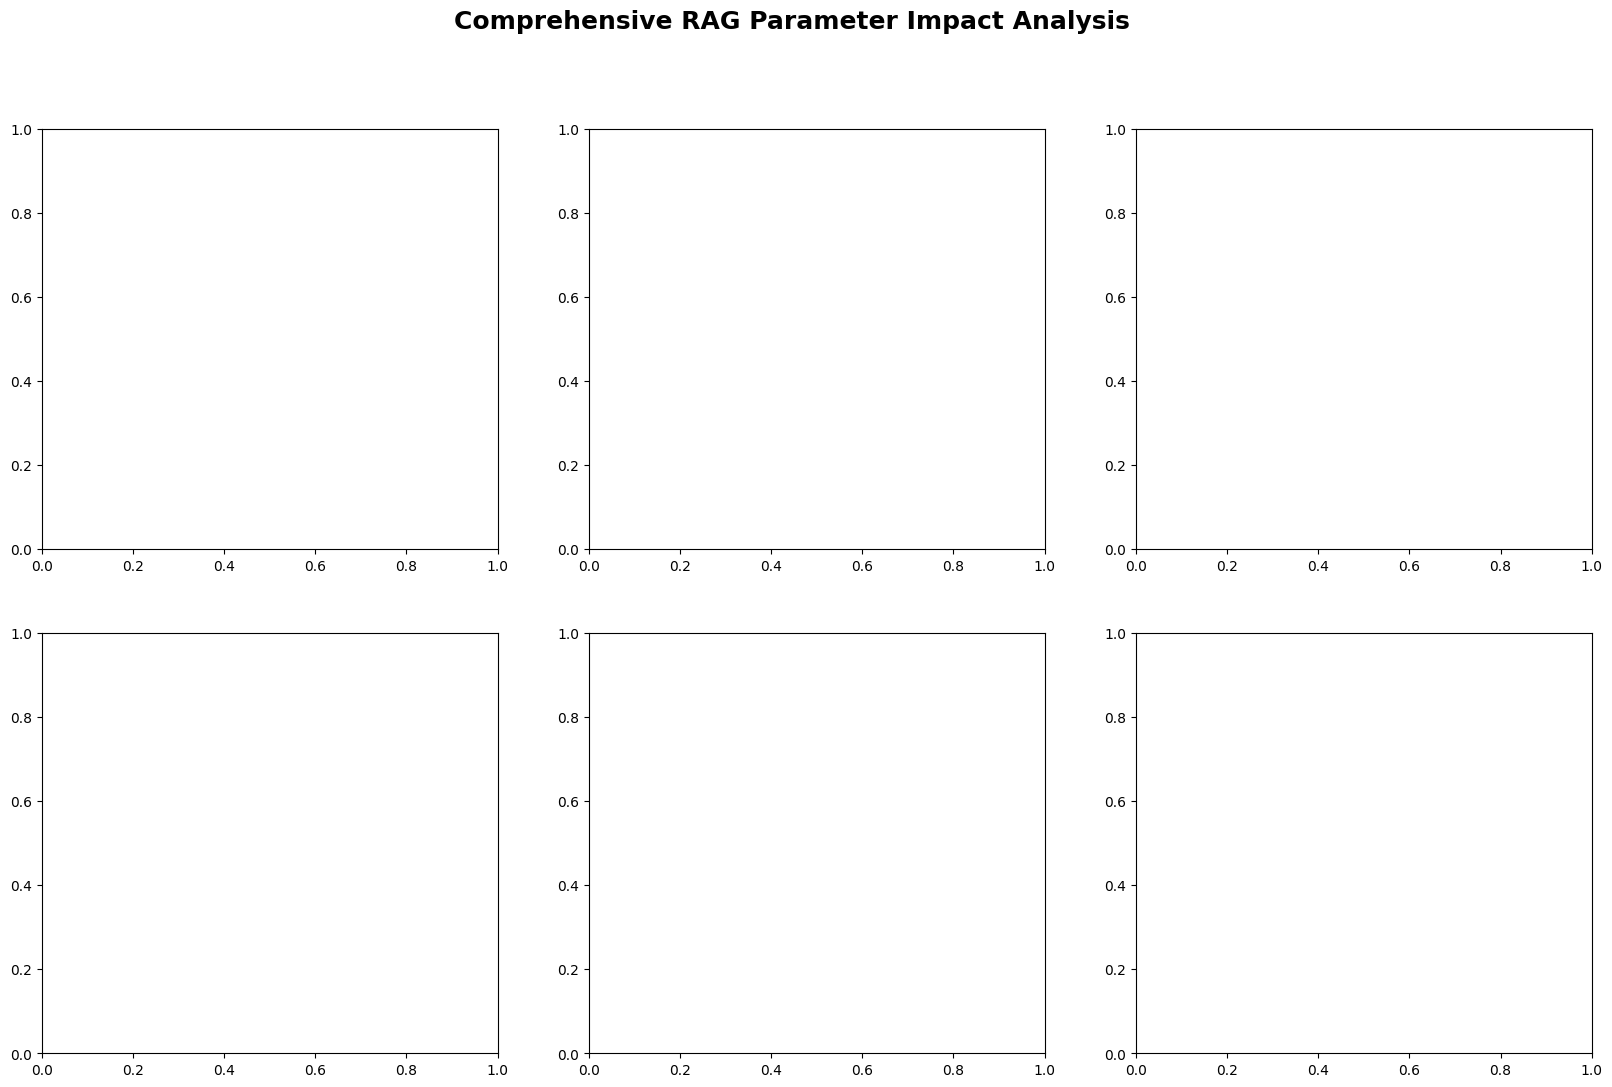

In [7]:
# Create comprehensive comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Comprehensive RAG Parameter Impact Analysis', fontsize=18, fontweight='bold')

# 1. Chunk Size Impact (Faithfulness)
ax1 = axes[0, 0]
values = [chunk_results[size].iloc[0]['faithfulness'] for size in chunk_sizes]
ax1.plot(chunk_sizes, values, 'o-', linewidth=3, markersize=8, color='#FF6B6B')
ax1.set_xlabel('Chunk Size (characters)')
ax1.set_ylabel('Faithfulness')
ax1.set_title('Chunk Size → Faithfulness')
ax1.grid(True, alpha=0.3)

# 2. Embedding Model Impact (Answer Relevancy)
ax2 = axes[0, 1]
embedding_values = []
embedding_labels = []
for model in embedding_models:
    if embedding_results[model] is not None:
        embedding_values.append(embedding_results[model].iloc[0]['answer_relevancy'])
        embedding_labels.append(model.replace('text-embedding-', '').replace('-', ' ').title())
ax2.bar(range(len(embedding_values)), embedding_values, color=['#4ECDC4', '#45B7D1', '#96CEB4'])
ax2.set_xlabel('Embedding Model')
ax2.set_ylabel('Answer Relevancy')
ax2.set_title('Embedding Model → Answer Relevancy')
ax2.set_xticks(range(len(embedding_values)))
ax2.set_xticklabels(embedding_labels, rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Prompt Design Impact (Answer Correctness)
ax3 = axes[0, 2]
prompt_values = [prompt_results[name].iloc[0]['answer_correctness'] for name in prompt_names]
ax3.bar(range(len(prompt_values)), prompt_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax3.set_xlabel('Prompt Design')
ax3.set_ylabel('Answer Correctness')
ax3.set_title('Prompt Design → Answer Correctness')
ax3.set_xticks(range(len(prompt_values)))
ax3.set_xticklabels(prompt_names, rotation=45)
ax3.grid(True, alpha=0.3)

# 4. Retrieval Strategy Impact (Context Precision)
ax4 = axes[1, 0]
retrieval_values = [basic_results.iloc[0]['context_precision'], advanced_results.iloc[0]['context_precision']]
ax4.bar(['Basic', 'MultiQuery'], retrieval_values, color=['#FF6B6B', '#4ECDC4'])
ax4.set_xlabel('Retrieval Strategy')
ax4.set_ylabel('Context Precision')
ax4.set_title('Retrieval Strategy → Context Precision')
ax4.grid(True, alpha=0.3)

# 5. Overall Performance Heatmap
ax5 = axes[1, 1]
metrics_for_heatmap = ['faithfulness', 'answer_relevancy', 'answer_correctness', 'context_precision']
parameters = ['Chunk Size (1000)', 'Embedding (ada-002)', 'Prompt (Basic)', 'Retrieval (Basic)']

# Get baseline values
baseline_values = [
    chunk_results[1000].iloc[0]['faithfulness'],
    embedding_results['text-embedding-ada-002'].iloc[0]['answer_relevancy'],
    prompt_results['Basic'].iloc[0]['answer_correctness'],
    basic_results.iloc[0]['context_precision']
]

heatmap_data = np.array([baseline_values]).T
im = ax5.imshow(heatmap_data, cmap='RdYlGn', aspect='auto')
ax5.set_xticks([0])
ax5.set_xticklabels(['Baseline'])
ax5.set_yticks(range(len(parameters)))
ax5.set_yticklabels(parameters)
ax5.set_title('Baseline Performance Overview')

# Add text annotations
for i, value in enumerate(baseline_values):
    ax5.text(0, i, f'{value:.3f}', ha='center', va='center', fontweight='bold')

# 6. Key Insights
ax6 = axes[1, 2]
ax6.axis('off')
insights_text = '''
Key Insights:

🔍 Chunk Size:
• Too small: Misses context
• Too large: Includes noise
• Optimal: 1000-2000 chars

🧠 Embedding Models:
• Better models = better semantic understanding
• Direct impact on retrieval quality

📝 Prompt Design:
• Clear instructions improve faithfulness
• Structure affects answer quality

🔎 Retrieval Strategy:
• MultiQuery improves context relevance
• Better retrieval = better answers
'''
ax6.text(0.05, 0.95, insights_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

## Summary: Why These Changes Matter

### 1. **Chunk Size Impact**
- **Too small chunks** (500 chars): May break up important context, leading to incomplete information retrieval
- **Optimal chunks** (1000-2000 chars): Provide sufficient context while maintaining relevance
- **Too large chunks** (3000+ chars): Include irrelevant information, reducing precision

### 2. **Embedding Model Impact**
- **Better embedding models** understand semantic relationships more accurately
- **Direct correlation** between embedding quality and retrieval precision
- **Newer models** (text-embedding-3) show improved performance over older ones

### 3. **Prompt Design Impact**
- **Clear instructions** improve faithfulness by guiding the LLM to stick to context
- **Structured prompts** can improve answer correctness through step-by-step reasoning
- **Prompt engineering** is crucial for controlling LLM behavior

### 4. **Retrieval Strategy Impact**
- **MultiQueryRetriever** generates multiple query variations, improving context recall
- **Better retrieval** directly translates to better answer quality
- **Retrieval quality** is the foundation of RAG performance

### **The Chain Reaction**
1. **Better chunking** → More relevant context pieces
2. **Better embeddings** → More accurate similarity matching
3. **Better retrieval** → More relevant context for the LLM
4. **Better prompts** → More faithful and accurate answers
5. **Result**: Higher faithfulness, relevancy, and correctness scores

This demonstrates why **systematic evaluation** and **parameter optimization** are crucial for building effective RAG systems!